In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib.cm as cm

PROCESS RAW DATA

In [4]:
import pandas as pd

file_path = "benchmark_raw_results.csv"  # path to your file
df = pd.read_csv(file_path, sep=';')

# -------------------------
# 1. Convert numeric columns
# -------------------------
numeric_cols = [
    'execution_time_ms',
    'alloc_mem_mb',
    'peak_mem_mb',
    'cpu_usage_percent'
]

for col in numeric_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(',', '.', regex=False)
        .apply(pd.to_numeric, errors='coerce')
    )

# -------------------------
# 2. Remove warm-up runs
# -------------------------
df = df[df['warm-up'] != 1]

# -------------------------
# 3. Drop unused columns
# -------------------------
columns_to_drop = ['run_id', 'timestamp', 'warm-up', 'notes']
df = df.drop(columns=columns_to_drop)

# -------------------------
# 4. Aggregation
# -------------------------
group_cols = ['matrix_size', 'vectorization', 'threads']

agg_dict = {
    'execution_time_ms': ['mean', 'median', 'std'],
    'alloc_mem_mb': ['mean', 'median', 'std'],
    'peak_mem_mb': ['mean', 'median', 'std'],
    'cpu_usage_percent': ['mean', 'median', 'std']
}

agg_df = df.groupby(group_cols).agg(agg_dict).reset_index()

# Flatten MultiIndex columns
agg_df.columns = ['_'.join(filter(None, col)).rstrip('_') for col in agg_df.columns]

# -------------------------
# 5. Round numeric columns to 2 decimals
# -------------------------
numeric_cols_agg = [col for col in agg_df.columns if col not in group_cols]
agg_df[numeric_cols_agg] = agg_df[numeric_cols_agg].round(2)

# -------------------------
# 6. Save aggregated results
# -------------------------
agg_df.to_csv('benchmark_aggregated_results.csv', index=False, sep=';')

print("Aggregated data saved as benchmark_aggregated_results.csv")
agg_df


Aggregated data saved as benchmark_aggregated_results.csv


,matrix_size,vectorization,threads,execution_time_ms_mean,execution_time_ms_median,execution_time_ms_std,alloc_mem_mb_mean,alloc_mem_mb_median,alloc_mem_mb_std,peak_mem_mb_mean,peak_mem_mb_median,peak_mem_mb_std,cpu_usage_percent_mean,cpu_usage_percent_median,cpu_usage_percent_std
0,64,none,1,0.14,0.12,0.06,1.94,1.94,0.0,0.13,0.00,0.51,2.78,0.00,3.82
1,64,none,2,0.21,0.16,0.17,1.97,1.97,0.0,0.27,0.00,0.71,4.02,4.62,2.97
2,64,none,4,0.20,0.19,0.06,1.97,1.97,0.0,0.40,0.00,0.83,2.47,0.00,3.44
3,64,none,6,0.18,0.16,0.05,1.97,1.97,0.0,0.27,0.00,0.71,2.78,0.00,3.42
4,64,none,8,0.19,0.17,0.05,1.97,1.97,0.0,0.00,0.00,0.00,3.70,4.63,3.98
5,64,none,10,0.24,0.21,0.10,1.97,1.97,0.0,0.27,0.00,0.71,2.47,0.00,3.44
6,64,simd,1,0.10,0.10,0.01,2.09,2.09,0.0,0.00,0.00,0.00,5.27,4.63,4.95
7,64,simd,2,0.33,0.33,0.04,2.09,2.09,0.0,0.14,0.00,0.55,2.67,0.00,3.67
8,64,simd,4,0.23,0.20,0.06,2.09,2.09,0.0,0.85,0.00,1.08,3.71,4.63,3.60
9,64,simd,6,0.21,0.19,0.08,2.09,2.09,0.0,0.28,0.00,0.75,3.08,0.00,3.77


GENERATE GRAPHS

In [163]:
def plot_lines(x: list, y: list, file_name: str, labels: list[str], title: str, xlabel: str, ylabel: str, figsize=(8,5), markers=True):
    """
    Plot multiple lines on a single graph with x values as ticks, and save it to a file.

    Parameters:
        x (list): X-axis values
        y (list of lists): Each inner list is a line's Y-axis values
        labels (list of str): Labels for each line
        title (str): Graph title
        xlabel (str): X-axis label
        ylabel (str): Y-axis label
        figsize (tuple, optional): Figure size
        markers (bool, optional): Show markers on data points
        file_name (str): Name of the file to save the plot in './graphs'
    """
    plt.figure(figsize=figsize)

    # Plot each line
    for i, y_values in enumerate(y):
        label = labels[i] if labels is not None else f"Line {i+1}"
        if markers:
            plt.plot(x, y_values, marker='o', label=label)
        else:
            plt.plot(x, y_values, label=label)

    # Set x-axis ticks to match x values
    plt.xticks(x, x, rotation=45)

    plt.grid(True, linestyle='--', alpha=0.5)
    if labels:
        plt.legend()
    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)

    plt.tight_layout()

    # Save plot
    os.makedirs('./graphs', exist_ok=True)
    full_path = os.path.join('./graphs', file_name)
    plt.savefig(full_path)
    print(f"Plot saved to {full_path}")

    plt.show()

In [164]:
def plot_lines(
    x: list,
    y: list,
    file_name: str,
    labels: list[str],
    title: str,
    xlabel: str,
    ylabel: str,
    figsize=(8,5),
    markers=True,
    line_colors: list = None  # optional colors
):
    """
    Plot multiple lines on a single graph with x values as ticks, and save it to a file.

    Parameters:
        x (list): X-axis values
        y (list of lists): Each inner list is a line's Y-axis values
        labels (list of str): Labels for each line
        title (str): Graph title
        xlabel (str): X-axis label
        ylabel (str): Y-axis label
        figsize (tuple, optional): Figure size
        markers (bool, optional): Show markers on data points
        file_name (str): Name of the file to save the plot in './graphs'
        line_colors (list, optional): List of colors for each line
    """
    plt.figure(figsize=figsize)

    # Plot each line
    for i, y_values in enumerate(y):
        label = labels[i] if labels is not None else f"Line {i+1}"
        color = line_colors[i] if line_colors is not None and i < len(line_colors) else None
        if markers:
            plt.plot(x, y_values, marker='o', label=label, color=color)
        else:
            plt.plot(x, y_values, label=label, color=color)

    # Set x-axis ticks to match x values
    plt.xticks(x, x, rotation=45)

    plt.grid(True, linestyle='--', alpha=0.5)
    if labels:
        plt.legend()
    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)

    plt.tight_layout()

    # Save plot
    os.makedirs('./graphs', exist_ok=True)
    full_path = os.path.join('./graphs', file_name)
    plt.savefig(full_path)
    print(f"Plot saved to {full_path}")

    plt.show()


In [165]:
sizes = [64, 128, 256, 512]
sparsities = [0, 50, 75, 90, 95]

Time and Optimized

Matrix sizes: [64, 128, 256, 512]
Sparsity 0%: [0.2565, 1.4544000000000001, 10.9113, 83.2269]
Sparsity 50%: [0.14140000000000003, 0.616, 4.0504, 22.19242857142857]
Sparsity 75%: [0.1059, 0.496, 1.8501, 10.340571428571428]
Sparsity 90%: [0.040499999999999994, 0.327, 1.0039, 7.815666666666668]
Sparsity 95%: [0.011, 0.10700000000000001, 0.5922, 3.2585714285714285]
Theoretical: [np.float64(0.2565), np.float64(1.026), np.float64(4.104), np.float64(16.416)]
Scale factor used: 6.26220703125e-05

Plot saved to ./graphs\time_mean_optimized_comparison_all_sparsities_vs_theoretical.png


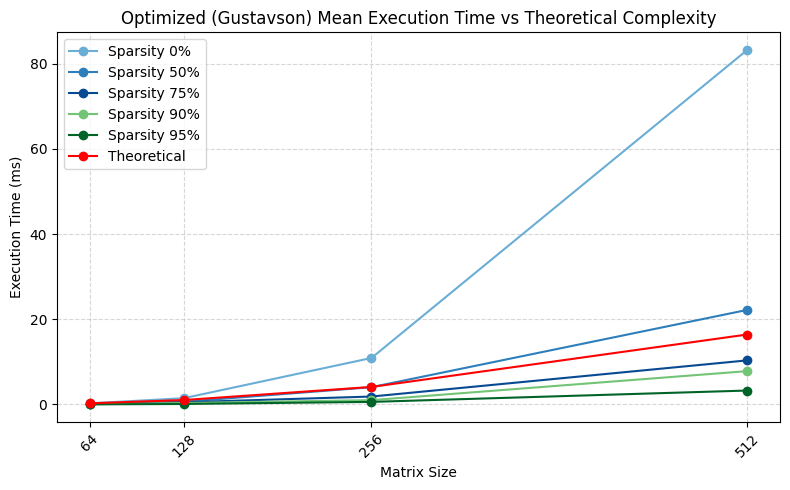

In [166]:
# Sort and filter optimized data
df_unopt = agg_df[agg_df['implementation'] == 'optimized'].sort_values(['sparse_level_percent', 'matrix_size'])

# Get unique sparsity levels and matrix sizes
sparsities = sorted(df_unopt['sparse_level_percent'].unique().tolist())
matrix_sizes = sorted(df_unopt['matrix_size'].unique().tolist())

# Collect execution times per sparsity
y_values = []
for s in sparsities:
    subset = df_unopt[df_unopt['sparse_level_percent'] == s]
    y_list = subset['execution_time_ms_mean'].tolist()
    y_values.append(y_list)

# Compute theoretical Gustavson time complexity
# nnz ~ n^2 * (1 - sparsity), simplified for dense case
dense_subset = df_unopt[df_unopt['sparse_level_percent'] == 0]
if not dense_subset.empty:
    scale_factor = dense_subset['execution_time_ms_mean'].iloc[0] / (matrix_sizes[0] ** 2)
else:
    scale_factor = 1

theoretical_gustavson_times = [scale_factor * n**2 for n in matrix_sizes]  # dense case

# Combine all data for plotting
y_all = y_values + [theoretical_gustavson_times]
labels_all = [f"Sparsity {s}%" for s in sparsities] + ["Theoretical"]

# -----------------------------
# Print data in requested list format
# -----------------------------
print(f"Matrix sizes: {matrix_sizes}")
for label, y_list in zip(labels_all, y_all):
    print(f"{label}: {y_list}")
print(f"Scale factor used: {scale_factor}\n")

# Generate line colors: gradient combining blues and greens for sparsities
num_sparsities = len(sparsities)
blue_shades = cm.Blues(np.linspace(0.5, 0.9, num_sparsities//2 + num_sparsities % 2))
green_shades = cm.Greens(np.linspace(0.5, 0.9, num_sparsities//2))
line_colors = list(blue_shades) + list(green_shades) + ['red']  # theoretical line in red

# Plot all lines
plot_lines(
    x=matrix_sizes,
    y=y_all,
    labels=labels_all,
    title='Optimized (Gustavson) Mean Execution Time vs Theoretical Complexity',
    xlabel='Matrix Size',
    ylabel='Execution Time (ms)',
    file_name='time_mean_optimized_comparison_all_sparsities_vs_theoretical.png',
    line_colors=line_colors
)


Matrix sizes: [64, 128, 256, 512]
Sparsity 0%: [0.2425, 1.4344999999999999, 10.2625, 76.676]
Sparsity 50%: [0.132, 0.502, 3.718, 22.069]
Sparsity 75%: [0.097, 0.469, 1.518, 9.825]
Sparsity 90%: [0.039, 0.3005, 0.9804999999999999, 6.016500000000001]
Sparsity 95%: [0.011, 0.108, 0.556, 3.21]
Plot saved to ./graphs\time_median_optimized_all_sparsities.png


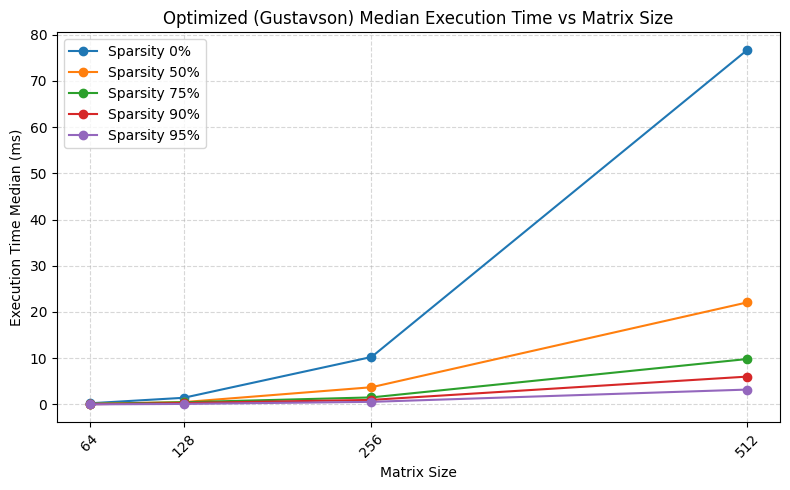

In [179]:

# Sort and filter optimized data
df_opt = agg_df[agg_df['implementation'] == 'optimized'].sort_values(['sparse_level_percent', 'matrix_size'])

# Get unique sparsity levels and matrix sizes
sparsities = sorted(df_opt['sparse_level_percent'].unique().tolist())
matrix_sizes = sorted(df_opt['matrix_size'].unique().tolist())

# Collect median execution times per sparsity
y_median_values = []
for s in sparsities:
    subset = df_opt[df_opt['sparse_level_percent'] == s]
    y_median_list = subset['execution_time_ms_median'].tolist()  # use median column
    y_median_values.append(y_median_list)

# Combine all data for plotting (no theoretical line)
y_all = y_median_values
labels_all = [f"Sparsity {s}%" for s in sparsities]

# -----------------------------
# Print data in requested list format
# -----------------------------
print(f"Matrix sizes: {matrix_sizes}")
for label, y_list in zip(labels_all, y_all):
    print(f"{label}: {y_list}")

# Generate line colors: gradient combining blues and greens for sparsities
num_sparsities = len(sparsities)
blue_shades = cm.Blues(np.linspace(0.5, 0.9, num_sparsities//2 + num_sparsities % 2))
green_shades = cm.Greens(np.linspace(0.5, 0.9, num_sparsities//2))

# Plot all lines
plot_lines(
    x=matrix_sizes,
    y=y_all,
    labels=labels_all,
    title='Optimized (Gustavson) Median Execution Time vs Matrix Size',
    xlabel='Matrix Size',
    ylabel='Execution Time Median (ms)',
    file_name='time_median_optimized_all_sparsities.png',
)


Matrix sizes: [64, 128, 256, 512]
Sparsity 0%: [0.05209233255586767, 0.07005109246511115, 2.3089053226342755, 15.992748519598221]
Sparsity 50%: [0.02829291234371055, 0.22025843406729695, 0.7898702003071981, 0.6510306846692796]
Sparsity 75%: [0.032195410300917805, 0.06213605144269216, 0.6743474953200644, 1.6762498677248625]
Sparsity 90%: [0.0044783429475148, 0.06678822251465198, 0.10737209445040488, 4.319208615784455]
Sparsity 95%: [0.0, 0.008393118874676114, 0.12581361876468966, 0.10661434728787232]
Plot saved to ./graphs\time_std_optimized_all_sparsities.png


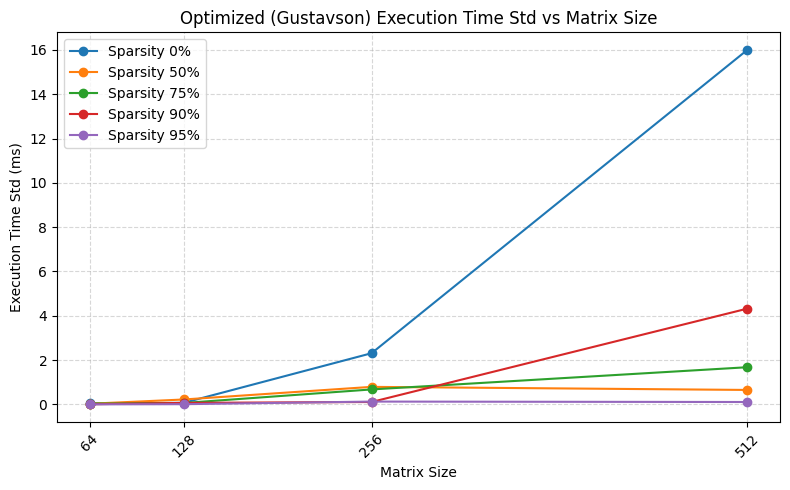

In [175]:

# Sort and filter optimized data
df_opt = agg_df[agg_df['implementation'] == 'optimized'].sort_values(['sparse_level_percent', 'matrix_size'])

# Get unique sparsity levels and matrix sizes
sparsities = sorted(df_opt['sparse_level_percent'].unique().tolist())
matrix_sizes = sorted(df_opt['matrix_size'].unique().tolist())

# Collect std of execution times per sparsity
y_std_values = []
for s in sparsities:
    subset = df_opt[df_opt['sparse_level_percent'] == s]
    y_std_list = subset['execution_time_ms_std'].tolist()  # use standard deviation
    y_std_values.append(y_std_list)

# Combine all data for plotting (no theoretical line)
y_all = y_std_values
labels_all = [f"Sparsity {s}%" for s in sparsities]

# -----------------------------
# Print data in requested list format
# -----------------------------
print(f"Matrix sizes: {matrix_sizes}")
for label, y_list in zip(labels_all, y_all):
    print(f"{label}: {y_list}")

# Generate line colors: gradient combining blues and greens for sparsities
num_sparsities = len(sparsities)
blue_shades = cm.Blues(np.linspace(0.5, 0.9, num_sparsities//2 + num_sparsities % 2))
green_shades = cm.Greens(np.linspace(0.5, 0.9, num_sparsities//2))

# Plot all lines
plot_lines(
    x=matrix_sizes,
    y=y_all,
    labels=labels_all,
    title='Optimized (Gustavson) Execution Time Std vs Matrix Size',
    xlabel='Matrix Size',
    ylabel='Execution Time Std (ms)',
    file_name='time_std_optimized_all_sparsities.png',
)


Time and Unoptimized

Matrix sizes: [64, 128, 256, 512]
Sparsity 0%: [18.1682, 129.4442, 3104.8367000000003, 48377.553700000004]
Sparsity 50%: [3.2911, 30.3522, 534.205, 12671.4394]
Sparsity 75%: [0.7455, 8.267100000000001, 133.9699, 3340.0673]
Sparsity 90%: [0.1484, 1.684, 24.1959, 312.2256]
Sparsity 95%: [0.0538, 0.4747, 7.4323999999999995, 86.8078]
Theoretical: [np.float64(18.1682), np.float64(145.3456), np.float64(1162.7648), np.float64(9302.1184)]
Plot saved to ./graphs\time_mean_unoptimized_comparison_all_sparsities_vs_theoretical.png


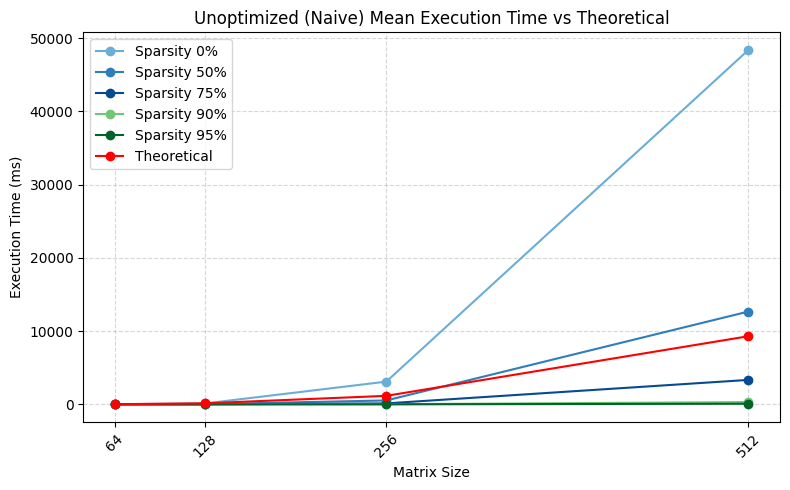

In [167]:
# Sort and filter unoptimized data
df_unopt = agg_df[agg_df['implementation'] == 'unoptimized'].sort_values(['sparse_level_percent', 'matrix_size'])

# Get unique sparsity levels and matrix sizes
sparsities = sorted(df_unopt['sparse_level_percent'].unique().tolist())
matrix_sizes = sorted(df_unopt['matrix_size'].unique().tolist())

# Collect execution times per sparsity
y_values = []
for s in sparsities:
    subset = df_unopt[df_unopt['sparse_level_percent'] == s]
    y_list = subset['execution_time_ms_mean'].tolist()
    y_values.append(y_list)

# Compute theoretical O(n^3) line
theoretical_raw = [n ** 3 for n in matrix_sizes]
dense_subset = df_unopt[df_unopt['sparse_level_percent'] == 0]
if not dense_subset.empty:
    scale_factor = dense_subset['execution_time_ms_mean'].iloc[0] / (matrix_sizes[0] ** 3)
else:
    scale_factor = 1
theoretical_naive_times = [scale_factor * t for t in theoretical_raw]

# Combine all data for plotting
y_all = y_values + [theoretical_naive_times]
labels_all = [f"Sparsity {s}%" for s in sparsities] + ["Theoretical"]

# Generate line colors: a gradient combining blues and greens for sparsities
num_sparsities = len(sparsities)
blue_shades = cm.Blues(np.linspace(0.5, 0.9, num_sparsities//2 + num_sparsities % 2))
green_shades = cm.Greens(np.linspace(0.5, 0.9, num_sparsities//2))
line_colors = list(blue_shades) + list(green_shades) + ['red']  # theoretical line in red

# -----------------------------
# Print data in requested list format
# -----------------------------
print(f"Matrix sizes: {matrix_sizes}")
for label, y_list in zip(labels_all, y_all):
    print(f"{label}: {y_list}")

# Plot all lines
plot_lines(
    x=matrix_sizes,
    y=y_all,
    labels=labels_all,
    title='Unoptimized (Naive) Mean Execution Time vs Theoretical',
    xlabel='Matrix Size',
    ylabel='Execution Time (ms)',
    file_name='time_mean_unoptimized_comparison_all_sparsities_vs_theoretical.png',
    line_colors=line_colors
)


Matrix sizes: [64, 128, 256, 512]
Sparsity 0%: [14.4515, 127.982, 3083.8, 51343.1805]
Sparsity 50%: [3.3285, 29.3505, 538.0225, 12768.953]
Sparsity 75%: [0.7525, 7.5245, 136.295, 3350.1315]
Sparsity 90%: [0.1495, 1.693, 24.509999999999998, 312.6405]
Sparsity 95%: [0.052, 0.48550000000000004, 7.306, 89.993]
Plot saved to ./graphs\time_median_unoptimized_all_sparsities.png


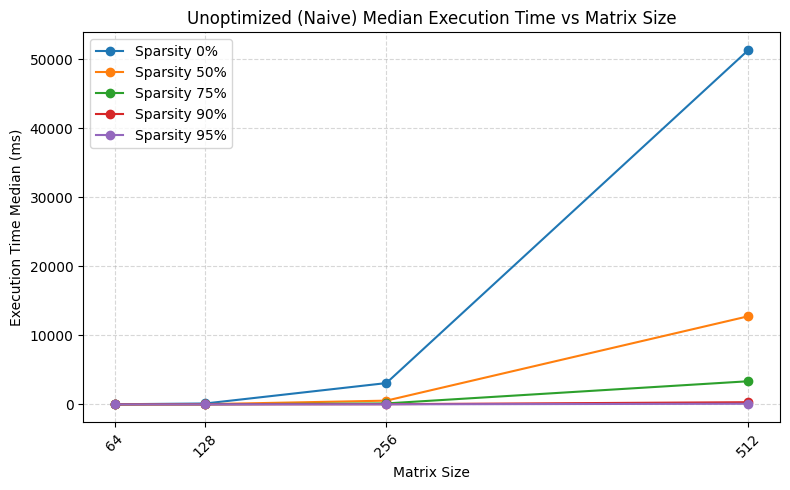

In [181]:

# Sort and filter unoptimized data
df_unopt = agg_df[agg_df['implementation'] == 'unoptimized'].sort_values(['sparse_level_percent', 'matrix_size'])

# Get unique sparsity levels and matrix sizes
sparsities = sorted(df_unopt['sparse_level_percent'].unique().tolist())
matrix_sizes = sorted(df_unopt['matrix_size'].unique().tolist())

# Collect median execution times per sparsity
y_median_values = []
for s in sparsities:
    subset = df_unopt[df_unopt['sparse_level_percent'] == s]
    y_median_list = subset['execution_time_ms_median'].tolist()  # use median column
    y_median_values.append(y_median_list)

# Combine all data for plotting (no theoretical line)
y_all = y_median_values
labels_all = [f"Sparsity {s}%" for s in sparsities]

# -----------------------------
# Print data in requested list format
# -----------------------------
print(f"Matrix sizes: {matrix_sizes}")
for label, y_list in zip(labels_all, y_all):
    print(f"{label}: {y_list}")

# Generate line colors: gradient combining blues and greens for sparsities
num_sparsities = len(sparsities)
blue_shades = cm.Blues(np.linspace(0.5, 0.9, num_sparsities//2 + num_sparsities % 2))
green_shades = cm.Greens(np.linspace(0.5, 0.9, num_sparsities//2))

# Plot all lines
plot_lines(
    x=matrix_sizes,
    y=y_all,
    labels=labels_all,
    title='Unoptimized (Naive) Median Execution Time vs Matrix Size',
    xlabel='Matrix Size',
    ylabel='Execution Time Median (ms)',
    file_name='time_median_unoptimized_all_sparsities.png',
)


Matrix sizes: [64, 128, 256, 512]
Sparsity 0%: [7.009029617413368, 12.817670500783935, 143.5510738773641, 7303.541862180508]
Sparsity 50%: [0.2935523614091511, 3.2238782648646445, 27.534683239708997, 802.4159149593461]
Sparsity 75%: [0.053606073453584646, 1.6365721255790169, 12.604262642719984, 70.7216831735501]
Sparsity 90%: [0.015196490822993743, 0.15056781417908233, 4.41989417796902, 25.739103486070896]
Sparsity 95%: [0.0035839146815241593, 0.07414108172936244, 1.062653199412782, 10.634533681465404]
Plot saved to ./graphs\time_std_unoptimized_all_sparsities.png


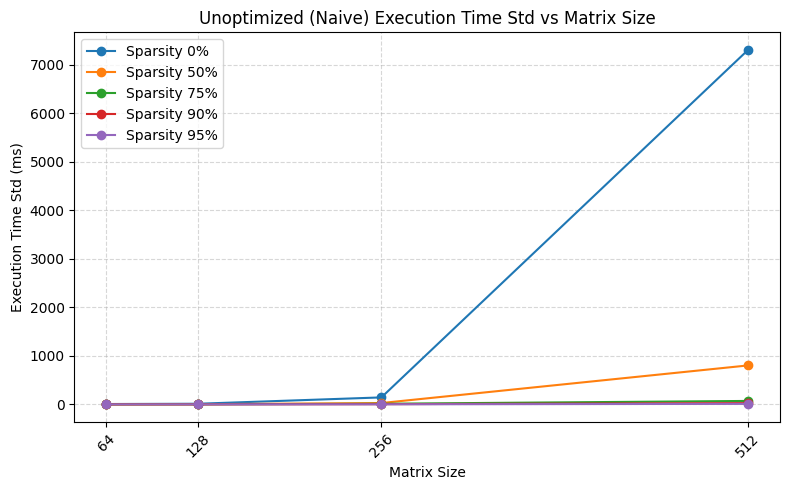

In [177]:


# Sort and filter unoptimized data
df_unopt = agg_df[agg_df['implementation'] == 'unoptimized'].sort_values(['sparse_level_percent', 'matrix_size'])

# Get unique sparsity levels and matrix sizes
sparsities = sorted(df_unopt['sparse_level_percent'].unique().tolist())
matrix_sizes = sorted(df_unopt['matrix_size'].unique().tolist())

# Collect standard deviation of execution times per sparsity
y_std_values = []
for s in sparsities:
    subset = df_unopt[df_unopt['sparse_level_percent'] == s]
    y_std_list = subset['execution_time_ms_std'].tolist()  # use std column
    y_std_values.append(y_std_list)

# Combine all data for plotting (no theoretical line)
y_all = y_std_values
labels_all = [f"Sparsity {s}%" for s in sparsities]

# -----------------------------
# Print data in requested list format
# -----------------------------
print(f"Matrix sizes: {matrix_sizes}")
for label, y_list in zip(labels_all, y_all):
    print(f"{label}: {y_list}")

# Generate line colors: gradient combining blues and greens for sparsities
num_sparsities = len(sparsities)
blue_shades = cm.Blues(np.linspace(0.5, 0.9, num_sparsities//2 + num_sparsities % 2))
green_shades = cm.Greens(np.linspace(0.5, 0.9, num_sparsities//2))

# Plot all lines
plot_lines(
    x=matrix_sizes,
    y=y_all,
    labels=labels_all,
    title='Unoptimized (Naive) Execution Time Std vs Matrix Size',
    xlabel='Matrix Size',
    ylabel='Execution Time Std (ms)',
    file_name='time_std_unoptimized_all_sparsities.png',
)


Memory and optimized

Matrix sizes: [64, 128, 256, 512]
Sparsity 0%: [0.1984, 1.1326, 4.3893, 24.4996]
Sparsity 50%: [0.18839999999999998, 0.922, 4.316599999999999, 24.829285714285714]
Sparsity 75%: [0.3987, 0.9601000000000001, 4.2919, 24.880714285714284]
Sparsity 90%: [0.15899999999999997, 0.8733000000000001, 3.7159, 18.552333333333333]
Sparsity 95%: [0.0, 0.2817, 1.7955999999999999, 14.055714285714286]
Theoretical: [np.float64(0.1984), np.float64(0.7936), np.float64(3.1744), np.float64(12.6976)]
Scale factor used: 4.84375e-05

Plot saved to ./graphs\memory_mean_optimized_comparison_all_sparsities_vs_theoretical.png


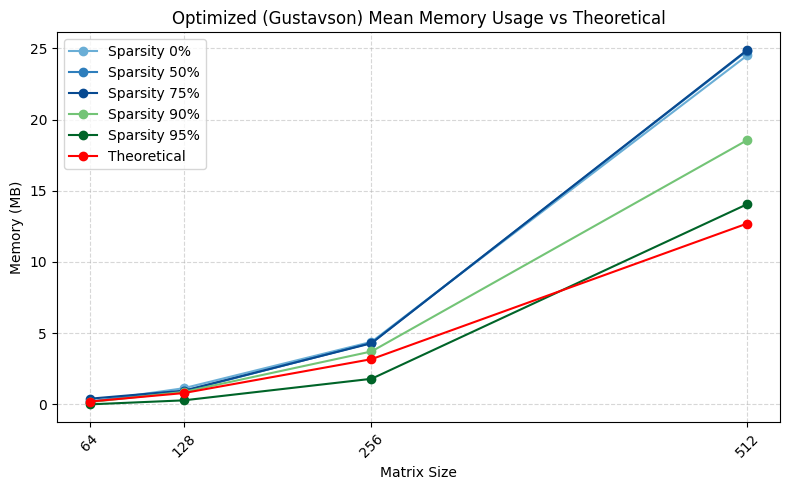

In [182]:
# Sort and filter optimized data
df_opt = agg_df[agg_df['implementation'] == 'optimized'].sort_values(['sparse_level_percent', 'matrix_size'])

# Get unique sparsity levels and matrix sizes
sparsities = sorted(df_opt['sparse_level_percent'].unique().tolist())
matrix_sizes = sorted(df_opt['matrix_size'].unique().tolist())

# Collect memory usage per sparsity
y_values = []
for s in sparsities:
    subset = df_opt[df_opt['sparse_level_percent'] == s]
    y_list = subset['memory_usage_mb_mean'].tolist()  # change column to memory
    y_values.append(y_list)

# Compute theoretical Gustavson memory complexity (dense case)
dense_subset = df_opt[df_opt['sparse_level_percent'] == 0]
if not dense_subset.empty:
    scale_factor = dense_subset['memory_usage_mb_mean'].iloc[0] / (matrix_sizes[0] ** 2)
else:
    scale_factor = 1

theoretical_memory = [scale_factor * n**2 for n in matrix_sizes]  # dense approximation

# Combine all data for plotting
y_all = y_values + [theoretical_memory]
labels_all = [f"Sparsity {s}%" for s in sparsities] + ["Theoretical"]

# -----------------------------
# Print data in requested list format
# -----------------------------
print(f"Matrix sizes: {matrix_sizes}")
for label, y_list in zip(labels_all, y_all):
    print(f"{label}: {y_list}")
print(f"Scale factor used: {scale_factor}\n")

# Generate line colors: gradient combining blues and greens for sparsities
num_sparsities = len(sparsities)
blue_shades = cm.Blues(np.linspace(0.5, 0.9, num_sparsities//2 + num_sparsities % 2))
green_shades = cm.Greens(np.linspace(0.5, 0.9, num_sparsities//2))
line_colors = list(blue_shades) + list(green_shades) + ['red']  # theoretical line in red

# Plot all lines
plot_lines(
    x=matrix_sizes,
    y=y_all,
    labels=labels_all,
    title='Optimized (Gustavson) Mean Memory Usage vs Theoretical',
    xlabel='Matrix Size',
    ylabel='Memory (MB)',
    file_name='memory_mean_optimized_comparison_all_sparsities_vs_theoretical.png',
    line_colors=line_colors
)


Matrix sizes: [64, 128, 256, 512]
Sparsity 0%: [0.0, 1.118, 4.335, 24.102]
Sparsity 50%: [0.0285, 0.9059999999999999, 4.383, 24.881]
Sparsity 75%: [0.408, 0.897, 4.4275, 24.998]
Sparsity 90%: [0.0, 0.81, 3.6125, 21.473999999999997]
Sparsity 95%: [0.0, 0.0, 1.9955, 14.125]
Plot saved to ./graphs\memory_median_optimized_all_sparsities.png


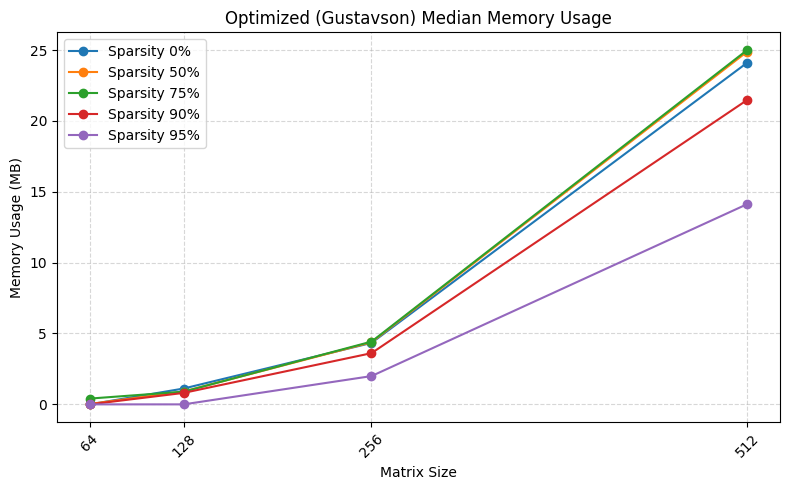

In [184]:

# Sort and filter optimized data
df_opt = agg_df[agg_df['implementation'] == 'optimized'].sort_values(['sparse_level_percent', 'matrix_size'])

# Get unique sparsity levels and matrix sizes
sparsities = sorted(df_opt['sparse_level_percent'].unique().tolist())
matrix_sizes = sorted(df_opt['matrix_size'].unique().tolist())

# Collect median memory usage per sparsity
y_median_values = []
for s in sparsities:
    subset = df_opt[df_opt['sparse_level_percent'] == s]
    y_median_list = subset['memory_usage_mb_median'].tolist()  # use median column
    y_median_values.append(y_median_list)

# Combine all data for plotting (no theoretical line)
y_all = y_median_values
labels_all = [f"Sparsity {s}%" for s in sparsities]

# -----------------------------
# Print data in requested list format
# -----------------------------
print(f"Matrix sizes: {matrix_sizes}")
for label, y_list in zip(labels_all, y_all):
    print(f"{label}: {y_list}")

# Generate line colors: gradient combining blues and greens for sparsities
num_sparsities = len(sparsities)
blue_shades = cm.Blues(np.linspace(0.5, 0.9, num_sparsities//2 + num_sparsities % 2))
green_shades = cm.Greens(np.linspace(0.5, 0.9, num_sparsities//2))

# Plot all lines
plot_lines(
    x=matrix_sizes,
    y=y_all,
    labels=labels_all,
    title='Optimized (Gustavson) Median Memory Usage',
    xlabel='Matrix Size',
    ylabel='Memory Usage (MB)',
    file_name='memory_median_optimized_all_sparsities.png',
)


Matrix sizes: [64, 128, 256, 512]
Sparsity 0%: [0.25677149374492486, 0.17795018029399876, 0.1886254666439999, 0.516744338247757]
Sparsity 50%: [0.23337342512710302, 0.340625242099812, 0.2685869195127219, 0.40576911098378526]
Sparsity 75%: [0.035333490565687874, 0.32030660658535004, 0.36311597473962937, 0.34478433562915695]
Sparsity 90%: [0.20574957810136302, 0.23930689268988664, 0.351620202301669, 7.228642214597888]
Sparsity 95%: [0.0, 0.37441986236487684, 0.393882441570804, 0.16250406588320018]
Plot saved to ./graphs\memory_std_optimized_all_sparsities.png


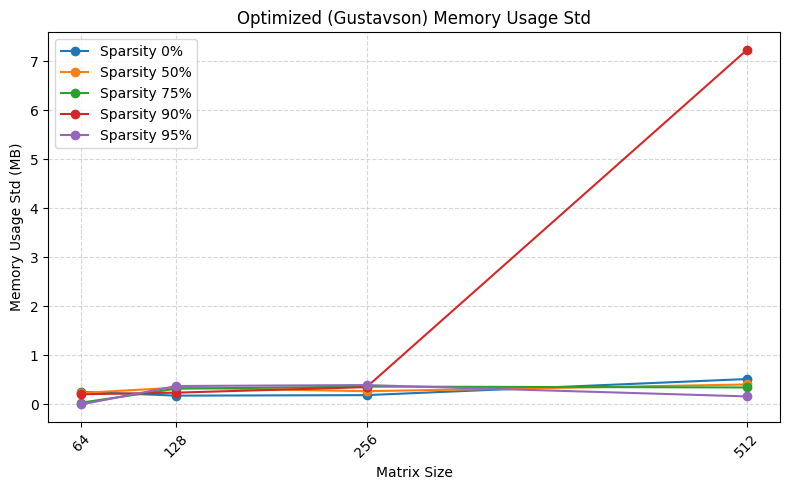

In [186]:

# Sort and filter optimized data
df_opt = agg_df[agg_df['implementation'] == 'optimized'].sort_values(['sparse_level_percent', 'matrix_size'])

# Get unique sparsity levels and matrix sizes
sparsities = sorted(df_opt['sparse_level_percent'].unique().tolist())
matrix_sizes = sorted(df_opt['matrix_size'].unique().tolist())

# Collect standard deviation of memory usage per sparsity
y_std_values = []
for s in sparsities:
    subset = df_opt[df_opt['sparse_level_percent'] == s]
    y_std_list = subset['memory_usage_mb_std'].tolist()  # use std column
    y_std_values.append(y_std_list)

# Combine all data for plotting (no theoretical line)
y_all = y_std_values
labels_all = [f"Sparsity {s}%" for s in sparsities]

# -----------------------------
# Print data in requested list format
# -----------------------------
print(f"Matrix sizes: {matrix_sizes}")
for label, y_list in zip(labels_all, y_all):
    print(f"{label}: {y_list}")

# Generate line colors: gradient combining blues and greens for sparsities
num_sparsities = len(sparsities)
blue_shades = cm.Blues(np.linspace(0.5, 0.9, num_sparsities//2 + num_sparsities % 2))
green_shades = cm.Greens(np.linspace(0.5, 0.9, num_sparsities//2))

# Plot all lines
plot_lines(
    x=matrix_sizes,
    y=y_all,
    labels=labels_all,
    title='Optimized (Gustavson) Memory Usage Std',
    xlabel='Matrix Size',
    ylabel='Memory Usage Std (MB)',
    file_name='memory_std_optimized_all_sparsities.png',
)


Memory and unoptimized

Matrix sizes: [64, 128, 256, 512]
Sparsity 0%: [0.3479, 1.2571999999999999, 4.013, 15.168600000000001]
Sparsity 50%: [0.1834, 0.6406000000000001, 2.3872, 9.4692]
Sparsity 75%: [0.1025, 0.34809999999999997, 1.4653, 4.7548]
Sparsity 90%: [0.05500000000000001, 0.1922, 0.6975, 3.1424]
Sparsity 95%: [0.037, 0.13090000000000002, 0.5142, 1.9702000000000002]
Theoretical: [np.float64(0.3479), np.float64(1.3916), np.float64(5.5664), np.float64(22.2656)]
Scale factor used: 8.49365234375e-05

Plot saved to ./graphs\memory_mean_unoptimized_all_sparsities_vs_theoretical.png


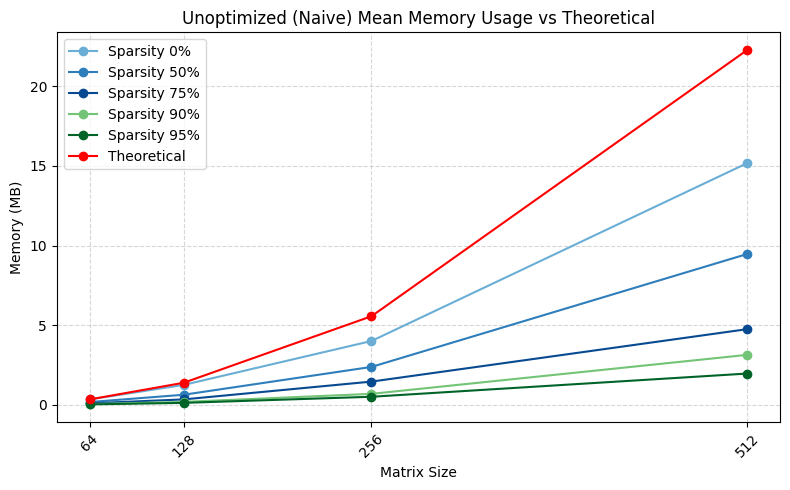

In [169]:
# Sort and filter unoptimized data
df_unopt = agg_df[agg_df['implementation'] == 'unoptimized'].sort_values(['sparse_level_percent', 'matrix_size'])

# Get unique sparsity levels and matrix sizes
sparsities = sorted(df_unopt['sparse_level_percent'].unique().tolist())
matrix_sizes = sorted(df_unopt['matrix_size'].unique().tolist())

# Collect memory usage per sparsity
y_values = []
for s in sparsities:
    subset = df_unopt[df_unopt['sparse_level_percent'] == s]
    y_list = subset['memory_usage_mb_mean'].tolist()  # column for memory
    y_values.append(y_list)

# Compute theoretical Gustavson memory complexity (dense case)
dense_subset = df_unopt[df_unopt['sparse_level_percent'] == 0]
if not dense_subset.empty:
    scale_factor = dense_subset['memory_usage_mb_mean'].iloc[0] / (matrix_sizes[0] ** 2)
else:
    scale_factor = 1

theoretical_memory = [scale_factor * n**2 for n in matrix_sizes]  # dense approximation

# Combine all data for plotting
y_all = y_values + [theoretical_memory]
labels_all = [f"Sparsity {s}%" for s in sparsities] + ["Theoretical"]

# -----------------------------
# Print data in requested list format
# -----------------------------
print(f"Matrix sizes: {matrix_sizes}")
for label, y_list in zip(labels_all, y_all):
    print(f"{label}: {y_list}")
print(f"Scale factor used: {scale_factor}\n")

# Generate line colors: gradient combining blues and greens for sparsities
num_sparsities = len(sparsities)
blue_shades = cm.Blues(np.linspace(0.5, 0.9, num_sparsities//2 + num_sparsities % 2))
green_shades = cm.Greens(np.linspace(0.5, 0.9, num_sparsities//2))
line_colors = list(blue_shades) + list(green_shades) + ['red']  # theoretical line in red

# Plot all lines
plot_lines(
    x=matrix_sizes,
    y=y_all,
    labels=labels_all,
    title='Unoptimized (Naive) Mean Memory Usage vs Theoretical',
    xlabel='Matrix Size',
    ylabel='Memory (MB)',
    file_name='memory_mean_unoptimized_all_sparsities_vs_theoretical.png',
    line_colors=line_colors
)


Matrix sizes: [64, 128, 256, 512]
Sparsity 0%: [0.304, 1.257, 4.013, 15.0405]
Sparsity 50%: [0.183, 0.64, 2.3855, 9.0665]
Sparsity 75%: [0.102, 0.3475, 1.461, 4.758]
Sparsity 90%: [0.055, 0.1925, 0.696, 2.945]
Sparsity 95%: [0.037, 0.13, 0.518, 1.958]
Plot saved to ./graphs\memory_median_unoptimized_all_sparsities.png


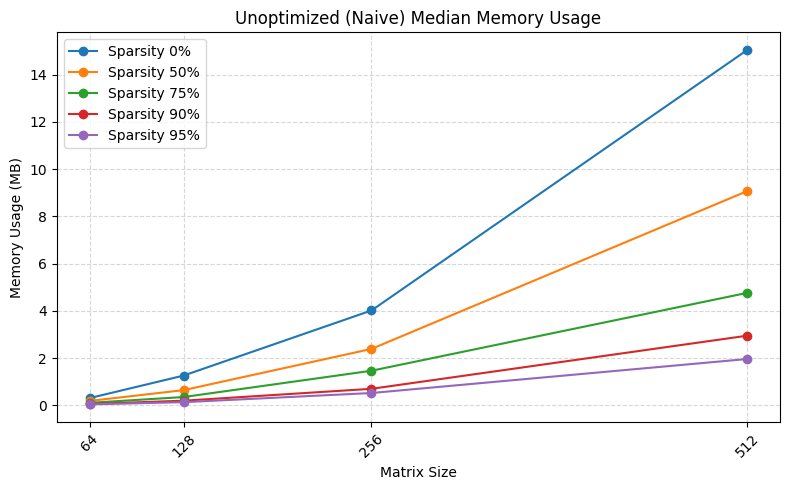

In [188]:

# Sort and filter unoptimized data
df_unopt = agg_df[agg_df['implementation'] == 'unoptimized'].sort_values(['sparse_level_percent', 'matrix_size'])

# Get unique sparsity levels and matrix sizes
sparsities = sorted(df_unopt['sparse_level_percent'].unique().tolist())
matrix_sizes = sorted(df_unopt['matrix_size'].unique().tolist())

# Collect median memory usage per sparsity
y_median_values = []
for s in sparsities:
    subset = df_unopt[df_unopt['sparse_level_percent'] == s]
    y_median_list = subset['memory_usage_mb_median'].tolist()  # use median column
    y_median_values.append(y_median_list)

# Combine all data for plotting (no theoretical line)
y_all = y_median_values
labels_all = [f"Sparsity {s}%" for s in sparsities]

# -----------------------------
# Print data in requested list format
# -----------------------------
print(f"Matrix sizes: {matrix_sizes}")
for label, y_list in zip(labels_all, y_all):
    print(f"{label}: {y_list}")

# Generate line colors: gradient combining blues and greens for sparsities
num_sparsities = len(sparsities)
blue_shades = cm.Blues(np.linspace(0.5, 0.9, num_sparsities//2 + num_sparsities % 2))
green_shades = cm.Greens(np.linspace(0.5, 0.9, num_sparsities//2))

# Plot all lines
plot_lines(
    x=matrix_sizes,
    y=y_all,
    labels=labels_all,
    title='Unoptimized (Naive) Median Memory Usage',
    xlabel='Matrix Size',
    ylabel='Memory Usage (MB)',
    file_name='memory_median_unoptimized_all_sparsities.png',
)


Matrix sizes: [64, 128, 256, 512]
Sparsity 0%: [0.0599545197999654, 0.0060332412515993255, 0.0, 0.70999517995234]
Sparsity 50%: [0.0016465452046971365, 0.00350238014308363, 0.030687673964204857, 1.1489588330310188]
Sparsity 75%: [0.0010801234497346457, 0.0033813212407775295, 0.029751003717895273, 0.14895994987467828]
Sparsity 90%: [0.0, 0.0030110906108363135, 0.010658851303546305, 0.45233424220002033]
Sparsity 95%: [0.0, 0.0023781411975649365, 0.010580905233275458, 0.023550418727110157]
Plot saved to ./graphs\memory_std_unoptimized_all_sparsities.png


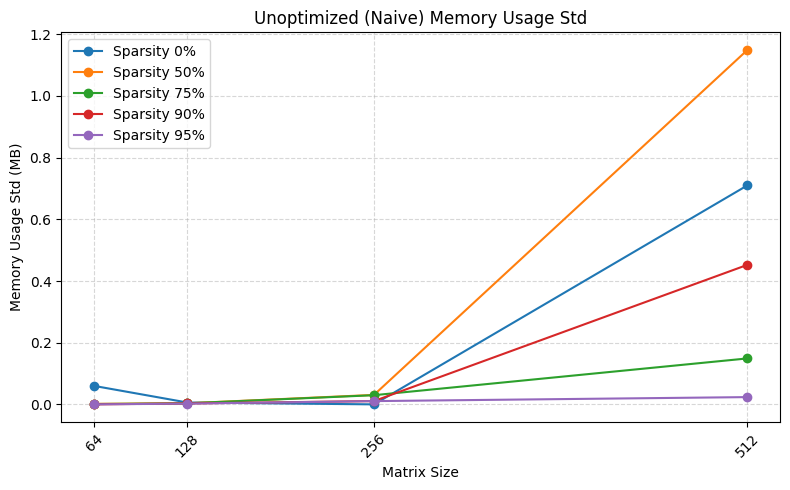

In [190]:

# Sort and filter unoptimized data
df_unopt = agg_df[agg_df['implementation'] == 'unoptimized'].sort_values(['sparse_level_percent', 'matrix_size'])

# Get unique sparsity levels and matrix sizes
sparsities = sorted(df_unopt['sparse_level_percent'].unique().tolist())
matrix_sizes = sorted(df_unopt['matrix_size'].unique().tolist())

# Collect standard deviation of memory usage per sparsity
y_std_values = []
for s in sparsities:
    subset = df_unopt[df_unopt['sparse_level_percent'] == s]
    y_std_list = subset['memory_usage_mb_std'].tolist()  # use std column
    y_std_values.append(y_std_list)

# Combine all data for plotting (no theoretical line)
y_all = y_std_values
labels_all = [f"Sparsity {s}%" for s in sparsities]

# -----------------------------
# Print data in requested list format
# -----------------------------
print(f"Matrix sizes: {matrix_sizes}")
for label, y_list in zip(labels_all, y_all):
    print(f"{label}: {y_list}")

# Generate line colors: gradient combining blues and greens for sparsities
num_sparsities = len(sparsities)
blue_shades = cm.Blues(np.linspace(0.5, 0.9, num_sparsities//2 + num_sparsities % 2))
green_shades = cm.Greens(np.linspace(0.5, 0.9, num_sparsities//2))
# Plot all lines
plot_lines(
    x=matrix_sizes,
    y=y_all,
    labels=labels_all,
    title='Unoptimized (Naive) Memory Usage Std',
    xlabel='Matrix Size',
    ylabel='Memory Usage Std (MB)',
    file_name='memory_std_unoptimized_all_sparsities.png',
)


Comparison in time

Matrix sizes: [64, 128, 256, 512]
Optimized 95%: [np.float64(0.011), np.float64(0.10700000000000001), np.float64(0.5922), np.float64(3.2585714285714285)]
Unoptimized 95%: [np.float64(0.0538), np.float64(0.4747), np.float64(7.4323999999999995), np.float64(86.8078)]
Plot saved to ./graphs\best_mean_time_optimized_vs_unoptimized_95.png


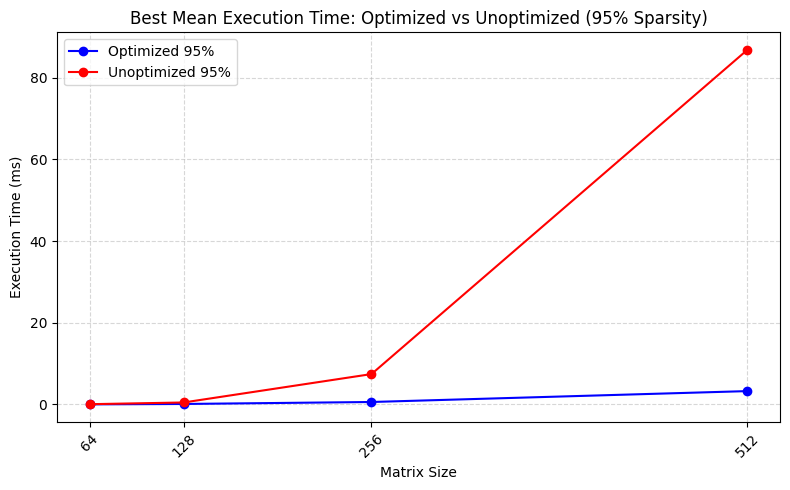

In [170]:
# Filter optimized and unoptimized data
df_opt = agg_df[(agg_df['implementation'] == 'optimized') & (agg_df['sparse_level_percent'] == 95)].sort_values('matrix_size')
df_unopt = agg_df[(agg_df['implementation'] == 'unoptimized') & (agg_df['sparse_level_percent'] == 95)].sort_values('matrix_size')

# Extract matrix sizes
matrix_sizes = sorted(df_opt['matrix_size'].unique().tolist())

# Get best (minimum) execution times for each matrix size
best_opt = [df_opt[df_opt['matrix_size'] == n]['execution_time_ms_mean'].min() for n in matrix_sizes]
best_unopt = [df_unopt[df_unopt['matrix_size'] == n]['execution_time_ms_mean'].min() for n in matrix_sizes]

# Print data in list format
print(f"Matrix sizes: {matrix_sizes}")
print(f"Optimized 95%: {best_opt}")
print(f"Unoptimized 95%: {best_unopt}")

# Plot lines
line_colors = ['blue', 'red']
labels = ['Optimized 95%', 'Unoptimized 95%']

plot_lines(
    x=matrix_sizes,
    y=[best_opt, best_unopt],
    labels=labels,
    title='Best Mean Execution Time: Optimized vs Unoptimized (95% Sparsity)',
    xlabel='Matrix Size',
    ylabel='Execution Time (ms)',
    file_name='best_mean_time_optimized_vs_unoptimized_95.png',
    line_colors=line_colors
)


Matrix sizes: [64, 128, 256, 512]
Optimized 0% (worst): [np.float64(0.2565), np.float64(1.4544000000000001), np.float64(10.9113), np.float64(83.2269)]
Unoptimized 0% (worst): [np.float64(18.1682), np.float64(129.4442), np.float64(3104.8367000000003), np.float64(48377.553700000004)]
Plot saved to ./graphs\worst_mean_time_optimized_vs_unoptimized_0.png


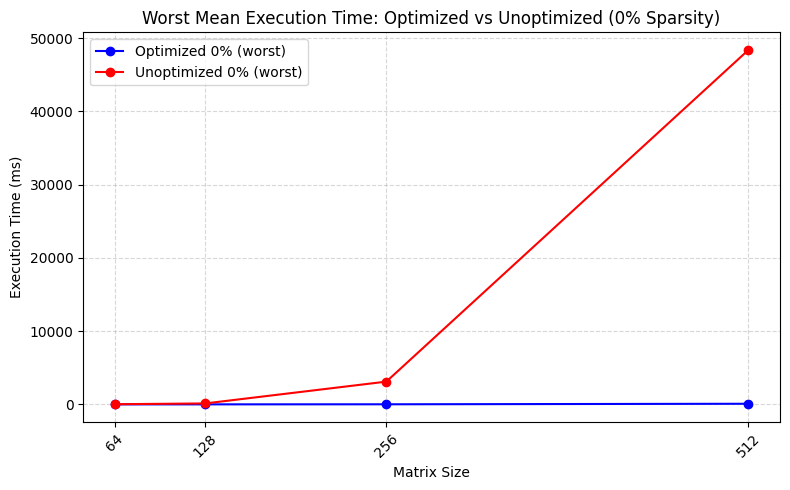

In [171]:
# Filter optimized and unoptimized data for 0% sparsity
df_opt = agg_df[(agg_df['implementation'] == 'optimized') & (agg_df['sparse_level_percent'] == 0)].sort_values('matrix_size')
df_unopt = agg_df[(agg_df['implementation'] == 'unoptimized') & (agg_df['sparse_level_percent'] == 0)].sort_values('matrix_size')

# Extract matrix sizes
matrix_sizes = sorted(df_opt['matrix_size'].unique().tolist())

# Get worst (maximum) execution times for each matrix size
worst_opt = [df_opt[df_opt['matrix_size'] == n]['execution_time_ms_mean'].max() for n in matrix_sizes]
worst_unopt = [df_unopt[df_unopt['matrix_size'] == n]['execution_time_ms_mean'].max() for n in matrix_sizes]

# Print data in list format
print(f"Matrix sizes: {matrix_sizes}")
print(f"Optimized 0% (worst): {worst_opt}")
print(f"Unoptimized 0% (worst): {worst_unopt}")

# Plot lines
line_colors = ['blue', 'red']
labels = ['Optimized 0% (worst)', 'Unoptimized 0% (worst)']

plot_lines(
    x=matrix_sizes,
    y=[worst_opt, worst_unopt],
    labels=labels,
    title='Worst Mean Execution Time: Optimized vs Unoptimized (0% Sparsity)',
    xlabel='Matrix Size',
    ylabel='Execution Time (ms)',
    file_name='worst_mean_time_optimized_vs_unoptimized_0.png',
    line_colors=line_colors
)


Comparison in memory

Matrix sizes: [64, 128, 256, 512]
Optimized 95%: [np.float64(0.0), np.float64(0.2817), np.float64(1.7955999999999999), np.float64(14.055714285714286)]
Unoptimized 95%: [np.float64(0.037), np.float64(0.13090000000000002), np.float64(0.5142), np.float64(1.9702000000000002)]
Plot saved to ./graphs\best_mean_memory_optimized_vs_unoptimized_95.png


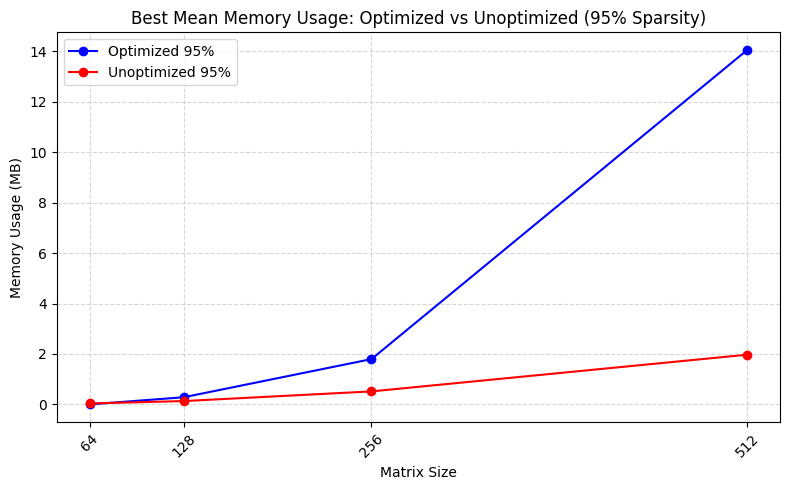

In [172]:
# Filter optimized and unoptimized data for 95% sparsity
df_opt = agg_df[(agg_df['implementation'] == 'optimized') & (agg_df['sparse_level_percent'] == 95)].sort_values('matrix_size')
df_unopt = agg_df[(agg_df['implementation'] == 'unoptimized') & (agg_df['sparse_level_percent'] == 95)].sort_values('matrix_size')

# Extract matrix sizes
matrix_sizes = sorted(df_opt['matrix_size'].unique().tolist())

# Get best (minimum) memory usage for each matrix size
best_opt_mem = [df_opt[df_opt['matrix_size'] == n]['memory_usage_mb_mean'].min() for n in matrix_sizes]
best_unopt_mem = [df_unopt[df_unopt['matrix_size'] == n]['memory_usage_mb_mean'].min() for n in matrix_sizes]

# Print data in list format
print(f"Matrix sizes: {matrix_sizes}")
print(f"Optimized 95%: {best_opt_mem}")
print(f"Unoptimized 95%: {best_unopt_mem}")

# Plot lines
line_colors = ['blue', 'red']
labels = ['Optimized 95%', 'Unoptimized 95%']

plot_lines(
    x=matrix_sizes,
    y=[best_opt_mem, best_unopt_mem],
    labels=labels,
    title='Best Mean Memory Usage: Optimized vs Unoptimized (95% Sparsity)',
    xlabel='Matrix Size',
    ylabel='Memory Usage (MB)',
    file_name='best_mean_memory_optimized_vs_unoptimized_95.png',
    line_colors=line_colors
)


Matrix sizes: [np.int64(64), np.int64(128), np.int64(256), np.int64(512)]
Optimized 75%: [np.float64(0.3987), np.float64(0.9601000000000001), np.float64(4.2919), np.float64(24.880714285714284)]
Unoptimized 0%: [np.float64(0.3479), np.float64(1.2571999999999999), np.float64(4.013), np.float64(15.168600000000001)]
Plot saved to ./graphs\worst_mean_memory_optimized_vs_unoptimized.png


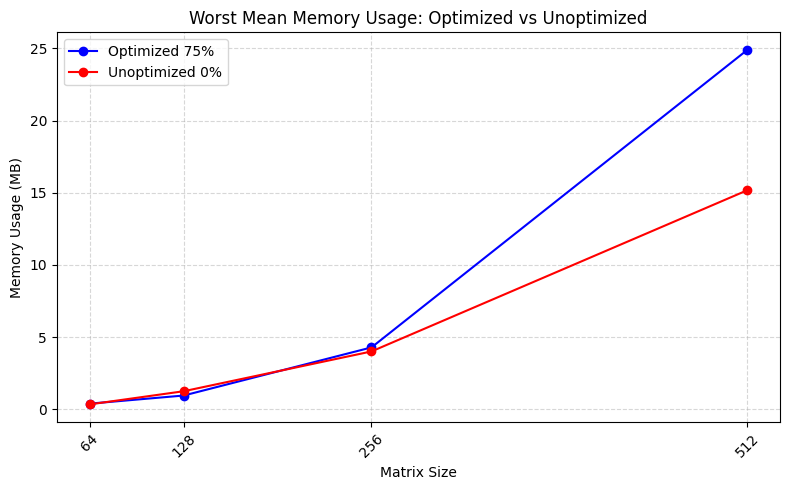

In [173]:
# Filter optimized (75%) and unoptimized (0%) data
df_opt = agg_df[(agg_df['implementation'] == 'optimized') & (agg_df['sparse_level_percent'] == 75)].sort_values('matrix_size')
df_unopt = agg_df[(agg_df['implementation'] == 'unoptimized') & (agg_df['sparse_level_percent'] == 0)].sort_values('matrix_size')

# Extract matrix sizes (common sizes for both)
matrix_sizes = sorted(list(set(df_opt['matrix_size'].unique()) & set(df_unopt['matrix_size'].unique())))

# Get worst (maximum) memory usage for each matrix size
worst_opt = [df_opt[df_opt['matrix_size'] == n]['memory_usage_mb_mean'].max() for n in matrix_sizes]
worst_unopt = [df_unopt[df_unopt['matrix_size'] == n]['memory_usage_mb_mean'].max() for n in matrix_sizes]

# Print data in list format
print(f"Matrix sizes: {matrix_sizes}")
print(f"Optimized 75%: {worst_opt}")
print(f"Unoptimized 0%: {worst_unopt}")

# Plot lines
line_colors = ['blue', 'red']
labels = ['Optimized 75%', 'Unoptimized 0%']

plot_lines(
    x=matrix_sizes,
    y=[worst_opt, worst_unopt],
    labels=labels,
    title='Worst Mean Memory Usage: Optimized vs Unoptimized',
    xlabel='Matrix Size',
    ylabel='Memory Usage (MB)',
    file_name='worst_mean_memory_optimized_vs_unoptimized.png',
    line_colors=line_colors
)
